# Transfer Learning on Sign Language Image Classification

The dataset of this notebook can be found at [Sign Language Gesture Images Dataset](https://www.kaggle.com/datasets/ahmedkhanak1995/sign-language-gesture-images-dataset/data)

## Imports

The following cells import the libraries needed for this project.

In [32]:
import tensorflow as tf
from pprint import pprint
from tqdm import tqdm
import matplotlib.pyplot as plt


In [33]:
!pip install seaborn

import seaborn as sns

## Load Dataset

The dataset is structured into folders. Each folder has the name of the `label` and contains all relevant `images` of this label.

This allows us to use the `image_dataset_from_directory` method from keras to quickly load the datase.

We __normalize__ the dataset and split it into:

- train set (80%)
- validation set (10%)
- test set (10%)


In [2]:
dataset_path = "/home/studio-lab-user/sign-language-image-detection/sign_datasets/sign-language-gesture-images-dataset/Gesture Image Data"

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    # Resize the images
    image_size=(96, 96),
    batch_size=64,
    shuffle=True
)

def normalize_image(image, label):
    precomputed_mean = [0.52732987, 0.4507709, 0.41209071]
    precomputed_std = [0.19798545, 0.23537221, 0.26049182]

    # Normalize the image
    image = (image / 255.0 - precomputed_mean) / precomputed_std
    return image, label

# Split the dataset into training, validation, and test sets
# Define the split ratios
train_size = int(0.7 * len(dataset))  # 80% for training
val_size = int(0.1 * len(dataset))   # 10% for validation
test_size = len(dataset) - train_size - val_size  # 10% for testing

# Create the training, validation, and test datasets
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

# Apply normalization to the datasets
train_dataset = train_dataset.map(normalize_image)
val_dataset = val_dataset.map(normalize_image)
test_dataset = val_dataset.map(normalize_image)

# Prefetching for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)


Found 55500 files belonging to 37 classes.


## Useful Methods

The following cells contain methods used to simplify the code

In [38]:
def get_class_count(dataset):
    class_counts = {}
    for images, labels in tqdm(dataset):
        for label in labels:
            # Here the label is a tensor with 1 element
            # We have to convert it to numpy
            label = label.numpy()
            # Count it
            class_counts[label] = class_counts.get(label, 0) + 1
    # Return the counts
    return class_counts

def plot_class_distribution(dataset, title: str):
    
    # Get the class counts
    class_counts = get_class_count(dataset)
    
    # Set the figure size
    plt.figure(figsize=(12, 6))
    # Add the data
    ax = sns.barplot(class_counts)
    # Set the title
    ax.set_title(title)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    # Adjust layout to make room for rotated labels
    plt.tight_layout()
    plt.show()
    
    
    # # Create a seaborn barplot
    # sns.barplot(class_counts).set_title(title)

## Visualizations

Bellow we can see some visualizations for this dataset

100%|██████████| 607/607 [00:10<00:00, 58.33it/s]


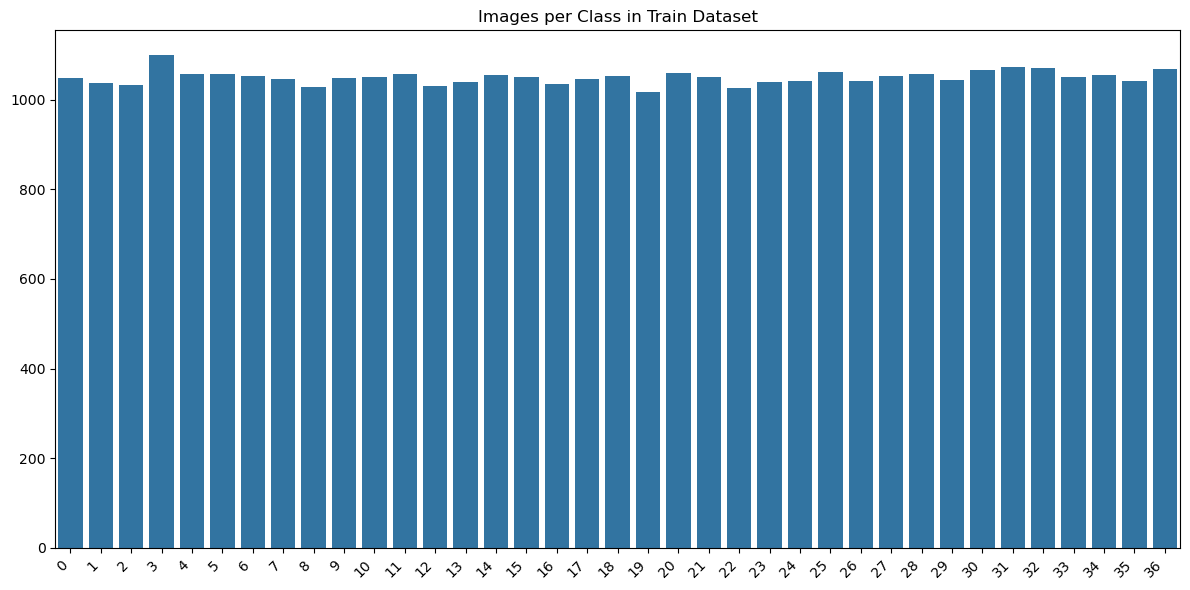

In [39]:
plot_class_distribution(train_dataset, "Images per Class in Train Dataset")

100%|██████████| 86/86 [00:01<00:00, 66.59it/s]


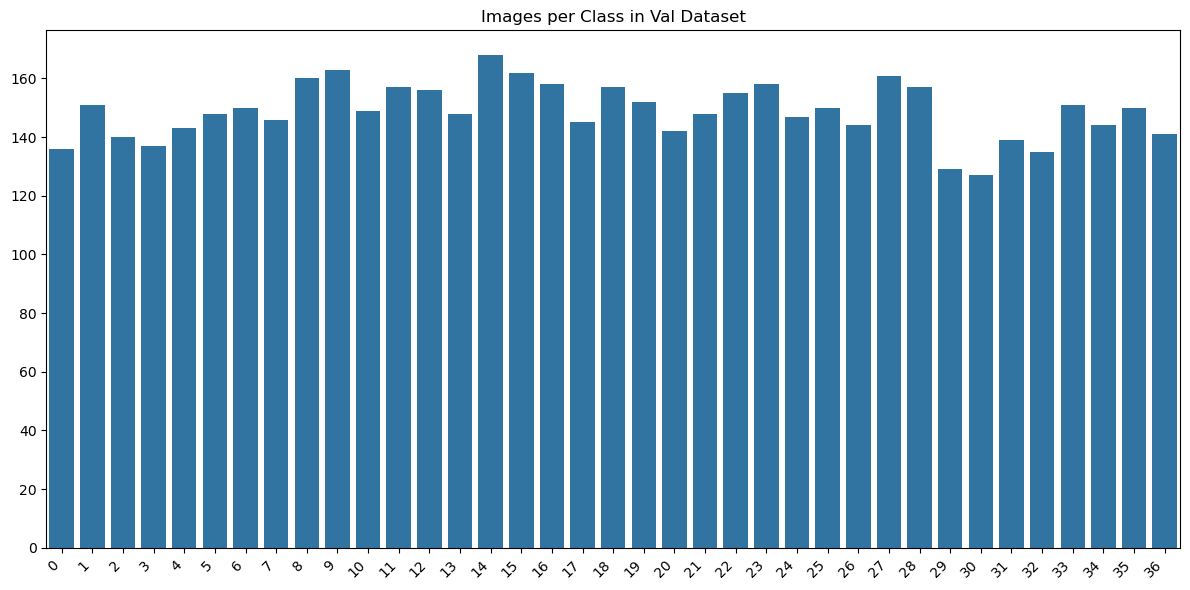

In [40]:
plot_class_distribution(val_dataset, "Images per Class in Val Dataset")

100%|██████████| 86/86 [00:01<00:00, 59.60it/s]


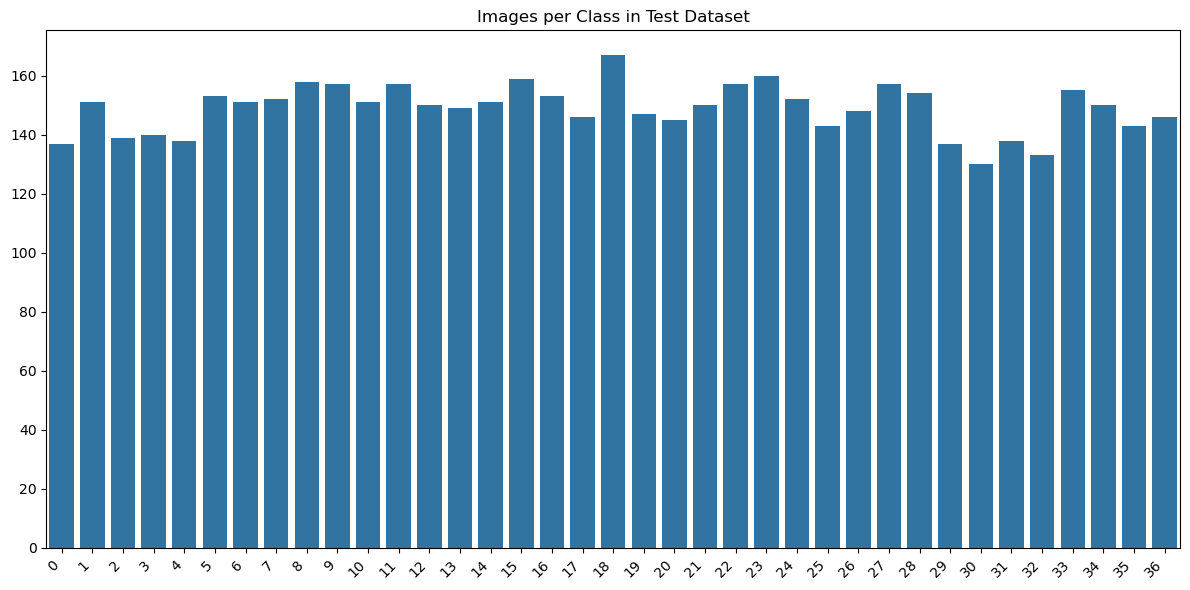

In [41]:
plot_class_distribution(test_dataset, "Images per Class in Test Dataset")

## MobileNet Transfer Learning

Let's try to finetune `MobileNetV2` for our task.

MobileNetV2 is trained on the `imagenet` dataset.

Due to the fact that it works with some specific image sizes, we have to reshape our images from (50, 50, 3) to (96, 96, 3)

In [44]:
# The include_top=False parameter imports the model without the FC layer at the end
base_model = tf.keras.applications.MobileNetV2(input_shape=(96, 96, 3),
                                               include_top=False,
                                               weights='imagenet')

class_names = dataset.class_names

# We dont want to train this model
base_model.trainable = False

# Add custom layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    # This is added to reduce the number of parameters
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 37)                4773      
                                                                 
Total params: 2426725 (9.26 MB)
Trainable params: 168741

## Additional Models

The following are simple tests __without finetuning__.

In [45]:
model = tf.keras.Sequential(
    [
    tf.keras.layers.Flatten(input_shape=(96, 96, 3)),
    tf.keras.layers.Dense(500, activation="relu"),
    tf.keras.layers.Dense(len(class_names), activation="softmax"),
    ]
)

adam = tf.keras.optimizers.Adam(learning_rate=1e-5)

print(model.summary())

model.compile(
    optimizer=adam,
    loss="sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

model.fit(train_dataset, epochs=1, validation_data=val_dataset)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 27648)             0         
                                                                 
 dense_22 (Dense)            (None, 500)               13824500  
                                                                 
 dense_23 (Dense)            (None, 37)                18537     
                                                                 
Total params: 13843037 (52.81 MB)
Trainable params: 13843037 (52.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
694/694 [==============================] - 118s 169ms/step - loss: 11.5951 - accuracy: 0.7448 - val_loss: 1.3612 - val_accuracy: 0.9339


In [47]:
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D
from keras.models import Sequential, save_model

model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu', input_shape=(96, 96 ,3) ))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.20))
model.add(Dense(37, activation = 'softmax'))

model.summary()

model.compile(optimizer='Adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=1)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 94, 94, 64)        1792      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 47, 47, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 45, 45, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 22, 22, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 20, 20, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 10, 10, 64)      